# ROC and AUC Exercise - Ian Liu

Please start from scratch to plot ROC and compute AUC for Logistic regression with spline transformation in "CIS335-logistic-and-ROC_AUC.ipynb"

You want to create a new notebook:

1. Create the dataset and split train-test sets

2. Train the mode (with spline transformation)

3. Evaluate the prediction score on test set and make the decision boundary plot.

4. Get array of Y_true (0 or 1 values) and Y_prob (float) , both are the same size.

5. Now you want determine a threshold grid, you do not use np.linspace() for this because there are many Y_prob values are identical or close to identical and there are regions that Y_prob values are very sparse. You get distinct values from Y_prob and then use these are threshold.

6. Compute TPR, FPR for each threshold (use the threshold to convert Y_prob into binary then compare with Y_true for TPR, FPT)

7. Plot ROC based on your TPR, FPR

8. Integrate the ROC curve to obtain the AUC (Since your ROC curve is  a step function so just adding up each rectangle is sufficient for this step ).

9. Compare your result with those obtained using sklearn package

Please add a section title for each step in your notebook.



https://github.com/scikit-learn/scikit-learn/blob/55a65a2fa5653257225d7e184da3d0c00ff852b1/sklearn/metrics/_ranking.py#L767

# 1. Dataset

## Create Dataset

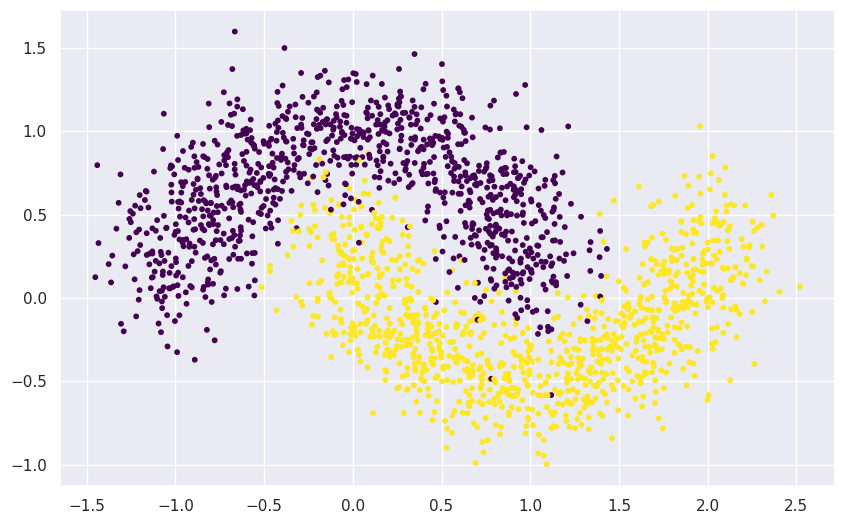

In [ ]:
%matplotlib inline
import matplotlib
matplotlib.rcParams['figure.figsize'] = [10, 6.18]

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

from sklearn.datasets import make_blobs, make_circles, make_moons
from sklearn.preprocessing import PolynomialFeatures, SplineTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

X,y = make_moons(n_samples=2000, noise=.2, random_state=42)
plt.scatter(X[:,0],X[:,1],c=y,s=10, cmap='viridis')

## Split to Training Testing Sets

In [ ]:
trainX,testX,trainY,testY = train_test_split(X,y)
print(trainX.shape, trainY.shape, testX.shape, testY.shape)

(1500, 2) (1500,) (500, 2) (500,)


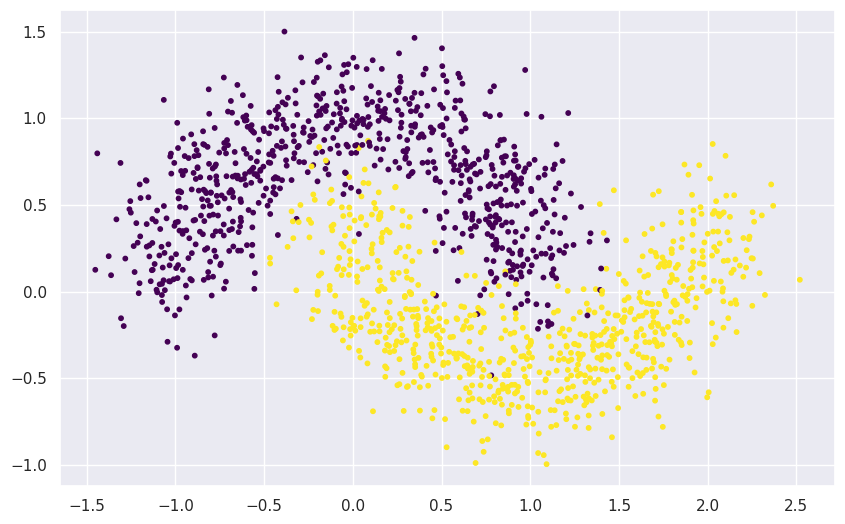

In [ ]:
plt.scatter(trainX[:,0],trainX[:,1],c=trainY,s=10, cmap='viridis')

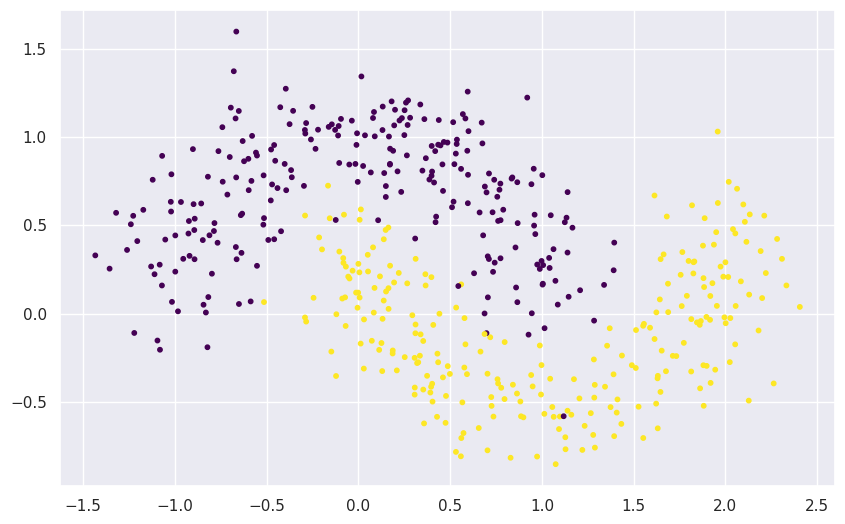

In [ ]:
plt.scatter(testX[:,0],testX[:,1],c=testY,s=10, cmap='viridis')

# 2. Train Model

(with spline transformation)

## Spline Transformation

In [ ]:
pol =  SplineTransformer(degree=3, n_knots=5)
trainX_tf = pol.fit_transform(trainX)
testX_tf = pol.fit_transform(testX)

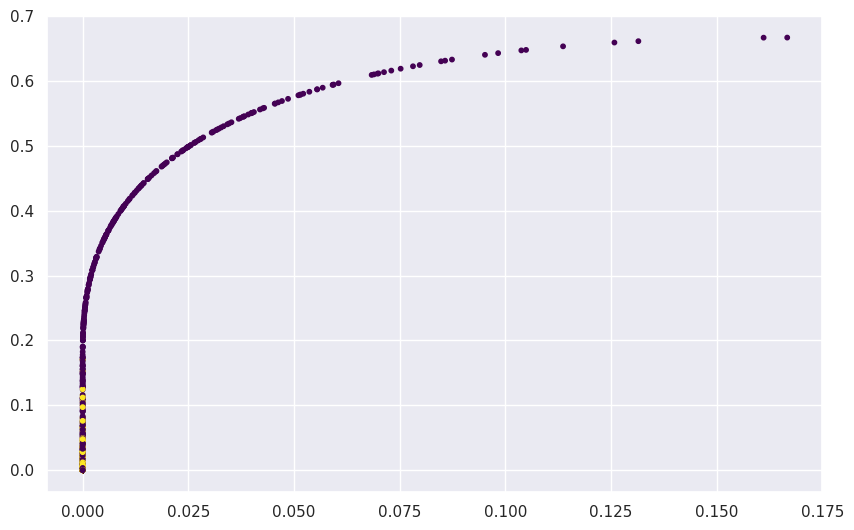

In [ ]:
plt.scatter(trainX_tf[:,0],trainX_tf[:,1],c=trainY,s=10, cmap='viridis')

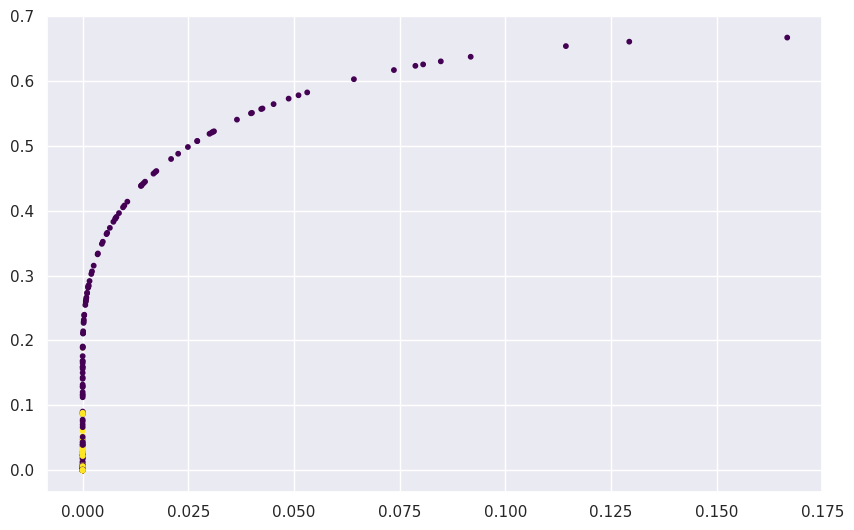

In [ ]:
plt.scatter(testX_tf[:,0],testX_tf[:,1],c=testY,s=10, cmap='viridis')

## Train Model using Transformed Data

In [ ]:
lr = LogisticRegression(penalty='l1', C=15, solver = 'saga')
lr.fit(trainX_tf,trainY)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


LogisticRegression(C=15, penalty='l1', solver='saga')

In [ ]:
lr.coef_

array([[  0.        , -51.66802286,  15.12759173,  -0.62567495,
         -5.95287976,  48.16801121,   0.        ,   0.        ,
         14.9800703 ,   6.44740789,   0.        ,  -4.63328218,
        -21.87544644,   0.        ]])

# 3. Evaluate

## Evaluate Prediction on Testing

In [ ]:
lr.score(testX_tf,testY)

0.958

## Make Decision Boundary Plot

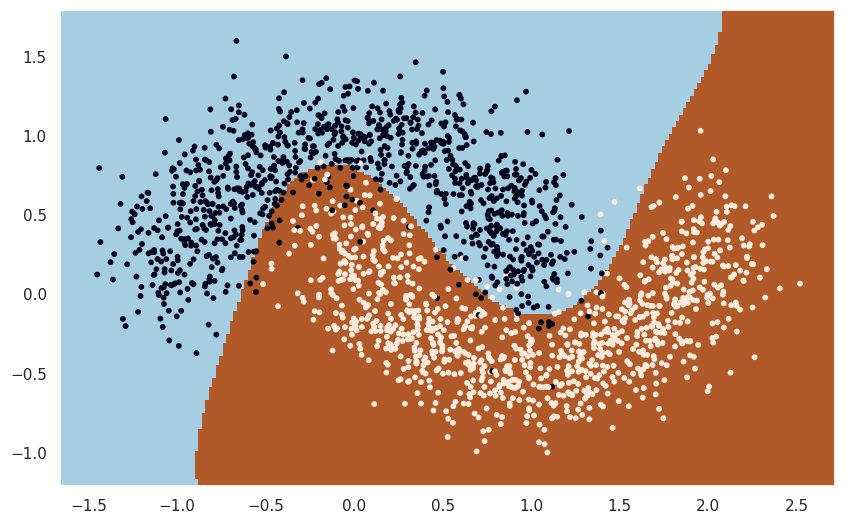

In [ ]:
h = .02; delt = 0.2
x_min, x_max = X[:, 0].min() - delt, X[:, 0].max() + delt
y_min, y_max = X[:, 1].min() - delt, X[:, 1].max() + delt
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

xx_tf = pol.fit_transform(np.c_[xx.ravel(), yy.ravel()])

Z = lr.predict(xx_tf)
Z = Z.reshape(xx.shape)

xx_tf = pol.fit_transform(np.c_[xx.ravel(), yy.ravel()])

Z = Z.reshape(xx.shape)
plt.pcolormesh(xx, yy, Z, cmap=plt.cm.Paired)
plt.scatter(X[:,0],X[:,1],c=y,s=10)

# 4. Get Ground Truth and Probabilities

Get array of Y_true (0 or 1 values) and Y_prob (float) , both are the same size.

In [ ]:
Y_true = testY
Y_pred = lr.predict(testX_tf)
Y_prob = lr.predict_proba(testX_tf)

Y_prob[:10]

array([[4.57031746e-10, 1.00000000e+00],
       [5.36171668e-02, 9.46382833e-01],
       [5.50249586e-03, 9.94497504e-01],
       [3.05089287e-13, 1.00000000e+00],
       [5.79797650e-01, 4.20202350e-01],
       [9.98867301e-01, 1.13269944e-03],
       [5.59101397e-05, 9.99944090e-01],
       [8.56640021e-01, 1.43359979e-01],
       [1.63668439e-02, 9.83633156e-01],
       [9.90387652e-01, 9.61234752e-03]])

# 5. Determine Threshold Grid


Now you want determine a threshold grid, you do not use np.linspace() for this because there are many Y_prob values are identical or close to identical and there are regions that Y_prob values are very sparse. You get distinct values from Y_prob and then use these are threshold.



In [ ]:
Y_prob_0 = np.unique(lr.predict_proba(testX_tf)[:,0])
Y_prob_1 = np.unique(lr.predict_proba(testX_tf)[:,1])
prob_threshold_grid = np.concatenate([Y_prob_0, Y_prob_1])
prob_threshold_grid = np.unique(prob_threshold_grid)
prob_threshold_grid = np.sort(prob_threshold_grid)
Y_prob_0.shape, Y_prob_1.shape, prob_threshold_grid.shape

((500,), (500,), (1000,))

# 6. Compute TPR & FPR for Thresholds

Compute TPR, FPR for each threshold (use the threshold to convert Y_prob into binary then compare with Y_true for TPR, FPT)

In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import classification_report, confusion_matrix
all_tpr = []
all_fpr = []


for indx, threshold in enumerate(prob_threshold_grid):
  new_pred = np.where(Y_prob[:, 1] > threshold, 1, 0)
  if indx % 100 == 0:
    print(f"Threshold: {threshold}")
    print(classification_report(y_true=Y_true, y_pred=new_pred))
  tn, fp, fn, tp = confusion_matrix(Y_true, new_pred).ravel()
  tpr = tp/(tp+fn)
  fpr = fp/(fp+tn)
  all_fpr.append(fpr)
  all_tpr.append(tpr)


Threshold: 2.220446049250313e-16
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       249
           1       0.50      1.00      0.67       251

    accuracy                           0.50       500
   macro avg       0.25      0.50      0.33       500
weighted avg       0.25      0.50      0.34       500



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Threshold: 5.438814503627711e-08
              precision    recall  f1-score   support

           0       1.00      0.16      0.28       249
           1       0.55      1.00      0.71       251

    accuracy                           0.58       500
   macro avg       0.77      0.58      0.49       500
weighted avg       0.77      0.58      0.50       500

Threshold: 0.00015065427020510835
              precision    recall  f1-score   support

           0       1.00      0.31      0.47       249
           1       0.59      1.00      0.74       251

    accuracy                           0.65       500
   macro avg       0.80      0.65      0.61       500
weighted avg       0.80      0.65      0.61       500

Threshold: 0.002152139732320979
              precision    recall  f1-score   support

           0       1.00      0.47      0.64       249
           1       0.65      1.00      0.79       251

    accuracy                           0.73       500
   macro avg       0.83      

# 7. Plot ROC

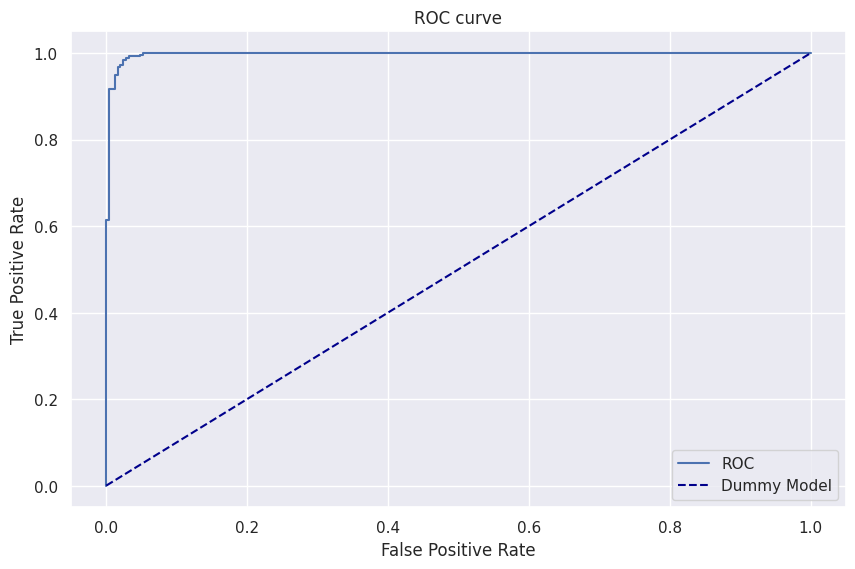

In [ ]:
plt.plot(all_fpr, all_tpr, label='ROC')
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--', label = 'Dummy Model')
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

# 8. Obtain AUC

via integration of ROC curve (Since your ROC curve is a step function so just adding up each rectangle is sufficient for this step )

In [ ]:
np.unique(all_tpr).shape, np.unique(all_fpr).shape

((252,), (250,))

Since there are more unique true positive rates, we will iterate over those.

In [ ]:
manual_auc_metric = 0
unique_tpr = np.unique(all_tpr)
unique_fpr = np.unique(all_fpr)

for i in range(len(unique_tpr)):

  ith_tpr = unique_tpr[i]
  y_point_1_indx = np.where(all_tpr == ith_tpr)[0][0]
  y_point_2_indx = np.where(all_tpr == ith_tpr)[0][-1]

  if y_point_1_indx == y_point_2_indx: continue

  x_point_1 = all_fpr[y_point_1_indx]
  x_point_2 = all_fpr[y_point_2_indx]

  if x_point_1 == x_point_2: continue

  manual_auc_metric += abs(x_point_1 - x_point_2) * ith_tpr

print('AUC')
print(manual_auc_metric)

AUC
0.9970719531512504


# 9. Compare with Scikit-Learn Results

https://github.com/scikit-learn/scikit-learn/blob/55a65a2fa5653257225d7e184da3d0c00ff852b1/sklearn/metrics/_ranking.py#L767

## Using `_binary_clf_curve()`

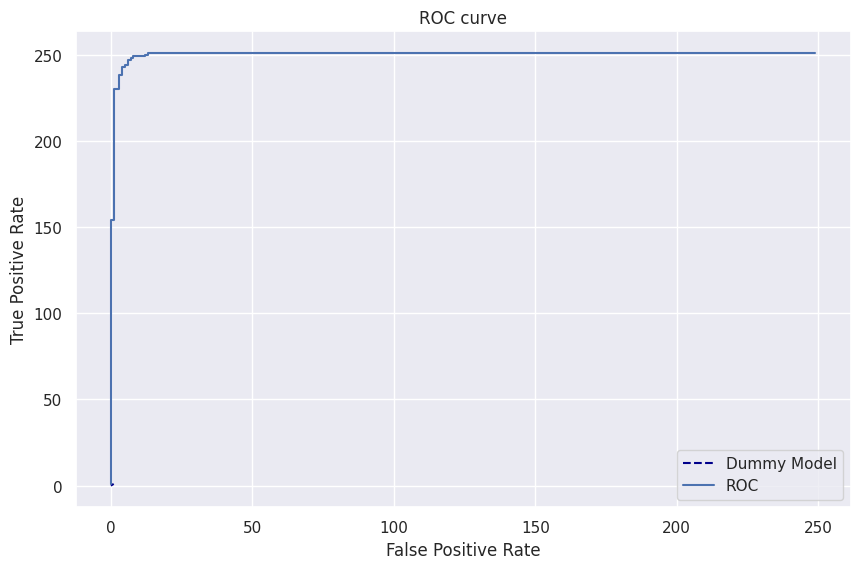

In [ ]:
from sklearn.metrics._ranking import _binary_clf_curve
sk_fps, sk_tps, sk_threshold = _binary_clf_curve(Y_true, Y_prob[:,1])

plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--', label = 'Dummy Model')
plt.plot(sk_fps, sk_tps, label='ROC')
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

## Using `roc_curve()` and `roc_auc_score()`

Area under the Receiver Operating Characteristic curve: 0.9970719531512504


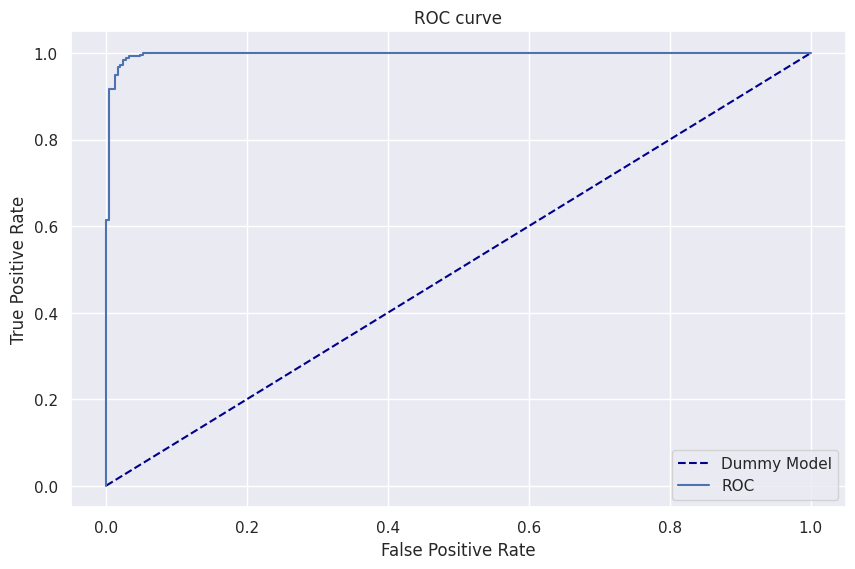

In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve

fpr, tpr, _ = roc_curve(y_true=Y_true, y_score=Y_prob[:,1])
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--', label = 'Dummy Model')
plt.plot(fpr, tpr, label='ROC')
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()

print('Area under the Receiver Operating Characteristic curve:',
      roc_auc_score(testY, Y_prob[:,1]))

In [ ]:
roc_auc_score(testY, Y_prob[:,1]) == manual_auc_metric

True

Our plot and metrics seem to correspond exactly the same.